# 3. Inductive biases and symmetries

**Group work:** It's time for group work! Form groups of 2 and work through the notebook together.

In the previous notebook, we saw that neural networks can be used to solve a large variety of tasks, ranging from image classification to XX. The main reason for the verstility of neural networks is two-fold: 1. neural networks are universal function approximators, meaning they can learn any function from data; and 2. surprisingly many tasks can be approximated as input-output relationships, i.e. functions. For example, we saw that digit classification can be achieved by learning a probability density function, $p(y | x)$, where $x$ denotes the pixels in the image, and $y$ denotes the digit. In this notebook, we dive deeper into some of the challenges of learning functions from data -- challenges that are important to understand when modelling language with neural networks.

More specifically, we focus on two related aspects of training neural networks: 1. the ability of neural networks to learn efficiently from data; and 2. the ability of neural networks to generalise beyond the training data.

**Learning outcomes:**

1. An intuitive understanding of architectural choices for neural networks
2. The limitations of learning functions from data (especially for extrapolation!)
3. The value of prior knowledge for more efficient learning and better generalisation

Credit goes to https://medium.com/@bpoyeka1/building-simple-neural-networks-nn-cnn-using-pytorch-for-mnist-dataset-31e459d17788 for providing a starting point of this notebook.

## 3.1 The limitations of learning functions from data: using MNIST as an example

In [42]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import torch
import torch.nn as nn  # all neural network modules
import torch.optim as optim  # optimization algo
import torch.nn.functional as F  # Functions with no parameters -> activation functions
from torch.utils.data import DataLoader  # easier dataset management, helps create mini batches
import torchvision.datasets as datasets  # standard datasets
import torchvision.transforms as transforms

In [2]:
class NN(nn.Module):  # inherits nn.Module

    def __init__(self, input_size, num_classes):  # input size = 28x28 = 784 for mnist
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.fc2 = nn.Linear(50, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [3]:
batch_size = 64

# Load Data
train_dataset = datasets.MNIST(root='dataset/', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root='dataset/', train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100.0%


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100.0%


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100.0%


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100.0%

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [4]:
# Set Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# Hyperparameters
input_size = 784
num_classes = 10
learning_rate = 0.001
num_epochs = 5

# Initialize Network
model = NN(input_size=input_size, num_classes=num_classes).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
# Train Network
for epoch in range(num_epochs):
# 1 epoch => Network has seen all the images in the dataset

    print(f'Epoch: {epoch}')

    for batch_idx, (data, targets) in enumerate(train_loader):

        data = data.to(device=device)
        targets = targets.to(device=device)

        # print(data.shape)  # => [64 , 1, 28, 28] => 64 : num_images, 1 -> num_channels, (28,28): (height, width)
        data = data.reshape(data.shape[0], -1)  # Flatten
        if epoch == 0 and batch_idx == 0:
            print(data.shape)

        # forward
        scores = model(data)

        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()  # set all gradients to zero for each batch
        loss.backward()

        # gradient descent
        optimizer.step()

Epoch: 0
torch.Size([64, 784])
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4


In [8]:
def check_accuracy(loader, model):

    if loader.dataset.train:
        print("Accuracy on training data")
    else:
        print("Accuracy on testing data")

    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():  # dont compute gradients
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            x = x.reshape(x.shape[0],-1)

            scores = model(x)
            _, predictions = scores.max(1)

            # print(predictions)

            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(f'Got {num_correct}/{num_samples} with accuracy {float(num_correct)/float(num_samples)*100: .2f}')

    model.train()


check_accuracy(train_loader, model)
check_accuracy(test_loader, model)

Accuracy on training data
Got 58355/60000 with accuracy  97.26
Accuracy on testing data
Got 9657/10000 with accuracy  96.57


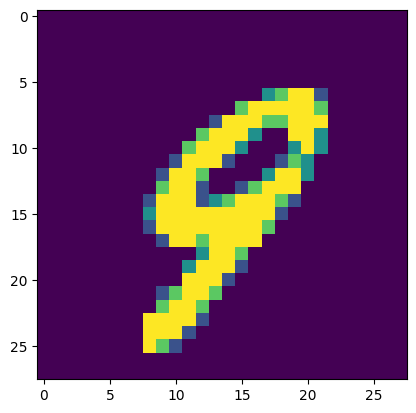

In [20]:
images, labels = next(iter(train_loader))
plt.imshow(images[0][0])
plt.show()

Padding

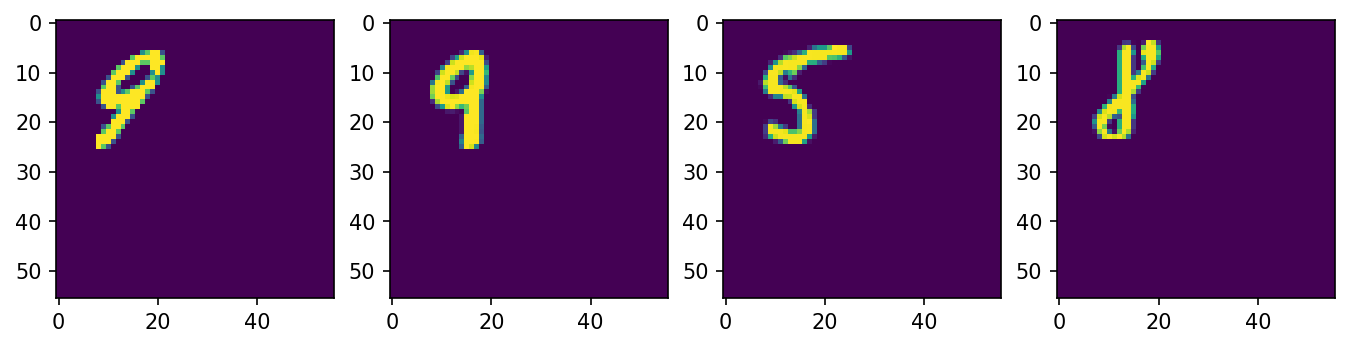

In [31]:
n_batch, n_channels, n_width, n_height = images.shape
padded = torch.zeros(size=(n_batch, n_channels, n_width*2, n_height*2))
padded[:, :, :n_width, :n_height] = images

# Create layout
fontsize = 14
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 1200 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 4)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))
axes.append(plt.Subplot(fig, outer[3]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

for ida, ax in enumerate(axes):
    ax.imshow(padded[ida][0])
plt.show()

In [21]:
images.shape

torch.Size([64, 1, 28, 28])

Run again

In [24]:
# Hyperparameters
input_size = 784 * 4
num_classes = 10
learning_rate = 0.001
num_epochs = 5

# Initialize Network
model = NN(input_size=input_size, num_classes=num_classes).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [25]:
# Train Network
for epoch in range(num_epochs):
# 1 epoch => Network has seen all the images in the dataset

    print(f'Epoch: {epoch}')

    for batch_idx, (data, targets) in enumerate(train_loader):
        # Pad images
        n_batch, n_channels, n_width, n_height = data.shape
        padded = torch.zeros(size=(n_batch, n_channels, n_width*2, n_height*2))
        padded[:, :, :n_width, :n_height] = data
        data = padded

        data = data.to(device=device)
        targets = targets.to(device=device)

        data = data.reshape(data.shape[0], -1)  # Flatten
        if epoch == 0 and batch_idx == 0:
            print(data.shape)

        # forward
        scores = model(data)

        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()  # set all gradients to zero for each batch
        loss.backward()

        # gradient descent
        optimizer.step()

Epoch: 0
torch.Size([64, 3136])
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4


In [26]:
def check_accuracy(loader, model):

    if loader.dataset.train:
        print("Accuracy on training data")
    else:
        print("Accuracy on testing data")

    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():  # dont compute gradients
        for x, y in loader:
            # Pad images
            n_batch, n_channels, n_width, n_height = x.shape
            padded = torch.zeros(size=(n_batch, n_channels, n_width*2, n_height*2))
            padded[:, :, :n_width, :n_height] = x
            x = padded

            x = x.to(device=device)
            y = y.to(device=device)
            x = x.reshape(x.shape[0],-1)

            scores = model(x)
            _, predictions = scores.max(1)

            # print(predictions)

            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(f'Got {num_correct}/{num_samples} with accuracy {float(num_correct)/float(num_samples)*100: .2f}')

    model.train()


check_accuracy(train_loader, model)
check_accuracy(test_loader, model)

Accuracy on training data
Got 58210/60000 with accuracy  97.02
Accuracy on testing data
Got 9637/10000 with accuracy  96.37


In [28]:
def check_accuracy_test2(model):

    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():  # dont compute gradients
        for x, y in test_loader:
            # Pad images
            n_batch, n_channels, n_width, n_height = x.shape
            padded = torch.zeros(size=(n_batch, n_channels, n_width*2, n_height*2))
            padded[:, :, -n_width:, -n_height:] = x
            x = padded

            x = x.to(device=device)
            y = y.to(device=device)
            x = x.reshape(x.shape[0],-1)

            scores = model(x)
            _, predictions = scores.max(1)

            # print(predictions)

            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(f'Got {num_correct}/{num_samples} with accuracy {float(num_correct)/float(num_samples)*100: .2f}')

    model.train()

check_accuracy_test2(model)

Got 901/10000 with accuracy  9.01


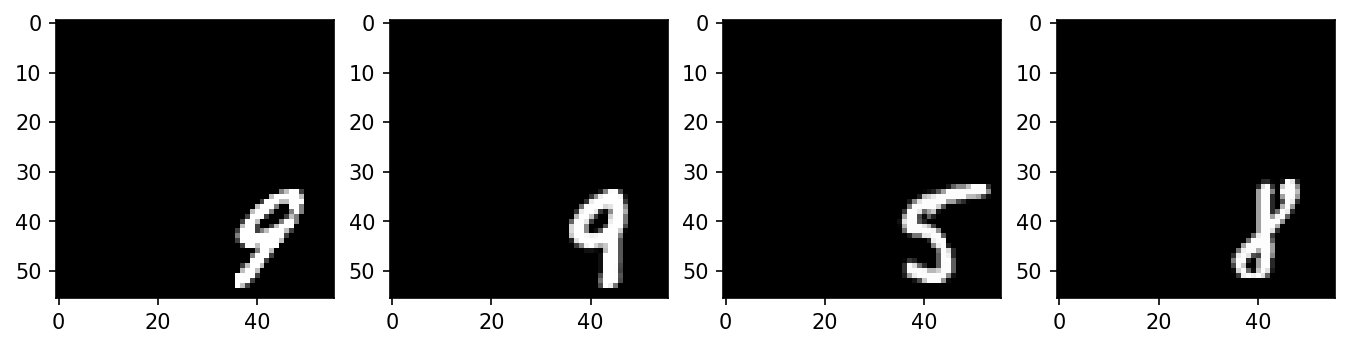

In [41]:
n_batch, n_channels, n_width, n_height = images.shape
padded = torch.zeros(size=(n_batch, n_channels, n_width*2, n_height*2))
padded[:, :, -n_width:, -n_height:] = images

# Create layout
fontsize = 14
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 1200 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 4)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))
axes.append(plt.Subplot(fig, outer[3]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

for ida, ax in enumerate(axes):
    ax.imshow(padded[ida][0], cmap='gray')
plt.show()

Why does the network not work? exercise discussion..

While neural can approximate any function, we only train their achieve these approximations only locally. This means that neural networks can only 